Clonato env tf-env <br>

conda create --name facedet --clone tf-env

# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
## !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [37]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()    

In [38]:
imgnum=0
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
#while True:
#    imgnum += 1
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [39]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\axc0462\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

A me non serve in quanto non ho GPU :-(

In [39]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

Importo le immagini contenute nella directory nel nostro tf.data.Dataset (https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Dataset usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [61]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
type(images)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

A titolo di esempio, estraggo la prima immagine dal nostro dataset

In [62]:
images.as_numpy_iterator().next()

b'data\\images\\c5134374-cfb4-11ec-8455-18cc18e03e9b.jpg'

Definisco una funzione che riceve in input il path dell'immagine e ritorna l'immagine stessa

In [63]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

Applico una trasformazione al nostro dataset: per ogni path di immagine presente, estraggo la corrispondente immagine. In pratica il nostro dataset prima conteneva tutti i path delle immagini presenti nella directoru, ora contiene le corrispondeti immagini

In [64]:
images = images.map(load_image)

In [65]:
images.as_numpy_iterator().next()

array([[[154, 146, 144],
        [152, 144, 142],
        [150, 145, 142],
        ...,
        [137, 140, 131],
        [134, 135, 129],
        [135, 136, 130]],

       [[150, 145, 142],
        [148, 143, 140],
        [147, 143, 140],
        ...,
        [134, 137, 128],
        [134, 135, 127],
        [135, 136, 128]],

       [[147, 146, 142],
        [143, 142, 138],
        [139, 140, 135],
        ...,
        [133, 136, 125],
        [135, 137, 126],
        [135, 137, 126]],

       ...,

       [[105,  99,  99],
        [104, 100,  99],
        [103, 102, 100],
        ...,
        [134, 136, 125],
        [133, 135, 124],
        [129, 131, 120]],

       [[114, 110, 111],
        [112, 108, 109],
        [107, 105, 106],
        ...,
        [136, 136, 126],
        [136, 136, 124],
        [132, 132, 120]],

       [[114, 110, 111],
        [110, 106, 107],
        [104, 102, 103],
        ...,
        [133, 133, 123],
        [136, 136, 124],
        [134, 134, 122]]

In [66]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

Utilizzando il metodo batch() il dataset restituisce le immagine contenute in batch di immagini.

Nel nostro caso batch di 4 immagini per poterle successivamente visualizzare

In [68]:
image_generator = images.batch(4).as_numpy_iterator()

In [69]:
plot_images = image_generator.next()

Utilizzando matplotlob, visualizziamo le 4 immagini presenti nel batch

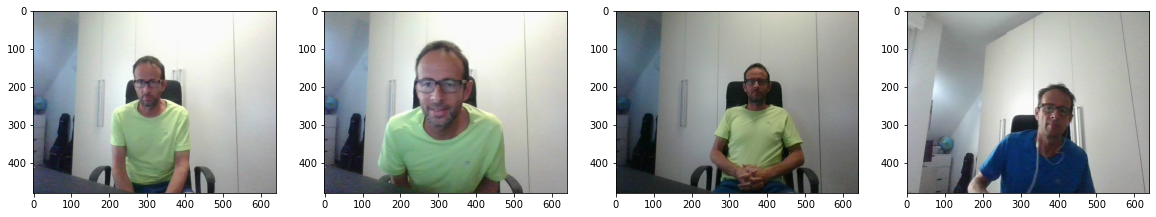

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

Vado a creare manualmente 3 directory per train, test, validation (ognuna con images e labels directory) e vado ad assegnare le immagini/annotations acquisite precedentemente alle rispettive directory (circa 70%, 15%, 15%)

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

Sposto le immagini e le labels nelle directory di destinazione

In [40]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [4]:
import albumentations as alb

Come primo devo creare una augmentation pipeline che effetui l'effettiva augmentation

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),   # le dimensioni devono essere inferiori a quelle originali
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

A titolo di esempio proviamo a prendere una immagine e a passarla nella nostra augmentation pipeline

In [71]:
# Lettura dell'immagine
img = cv2.imread(os.path.join('data','train', 'images','cc7dce29-cfb4-11ec-b984-18cc18e03e9b.jpg'))

In [72]:
# lettura della rispettiva annotation (viene creato un dictionary)
with open(os.path.join('data', 'train', 'labels', 'cc7dce29-cfb4-11ec-b984-18cc18e03e9b.json'), 'r') as f:
    label = json.load(f)

In [73]:
# dall'annotation estraggo le coordinate del bounding box (in formato Pascal VOC)
label['shapes'][0]['points']

[[483.3125, 91.66666666666667], [595.8125, 236.45833333333334]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In questo modo le coordinate vengono convertite dal formato Pascal VOC a formato albumentation

Converto le coordinate in modo che siano in un vettore monodimensionale

In [76]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [77]:
coords

[483.3125, 91.66666666666667, 595.8125, 236.45833333333334]

Divido le coordinate assolute per le dimensioni dell'immagine in modo da convertire da formato Pascal VOC a formato albumentations

In [78]:
coords = list(np.divide(coords, [640,480,640,480]))

In [79]:
coords

[0.75517578125, 0.19097222222222224, 0.93095703125, 0.4926215277777778]

### 4.4 Apply Augmentations and View Results

Ora è possibile elaborare l'immagine, le coordinate in formato albumentations e la classe nella augmentation pipeline 
precedentemente definita

Viene ritornato un dictionary

In [81]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [82]:
type(augmented)

dict

In [83]:
augmented['bboxes'][0][2:]

(0.33486111111111116, 0.8207407407407408)

In [20]:
augmented['bboxes']

[(0.8229166666666666, 0.15925925925925927, 1.0, 0.4810185185185185)]

Disegno il rettangolo con il bounding box sull'immagine originale.

Per ottenere le coordinate per disegnare il rettangolo, devo moltiplicare le coordinate in formato albumentations per le dimensioni dell'immagine

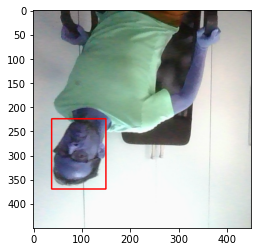

In [84]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)  # definisce il colore del rettangolo

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

Obiettivo è quello di eseguire l'augmentation pipeline su train, test e validation dataset.

Creo prima manualmente una directory aug_data con all'interno 3 cartelle x i 3 dataset (ognuna con images e labels)

In [23]:
# per ogni immagine presente nelle 3 directory

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        
        # leggo l'immagine
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        # inizializzo le coordinate del bb per il caso che non sia presente annotation (face non presente)
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        
        # Verifico se esiste una annotation corrispondente all'immagine e se esiste calcolo le coordinate in
        # formato albumentation
        #
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        # Per ogni immagine letta in input, creo 60 immagini "aumentate"
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

Da notare che l'immagine viene ridotta di dimensione (a 120x120)

In [85]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [86]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [87]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [88]:
train_images.as_numpy_iterator().next()

array([[[0.5009804 , 0.5833333 , 0.5588235 ],
        [0.48860294, 0.5709559 , 0.5464461 ],
        [0.49050245, 0.57775736, 0.55079657],
        ...,
        [0.5019608 , 0.575     , 0.59068626],
        [0.5140319 , 0.5810662 , 0.5980392 ],
        [0.511826  , 0.57800245, 0.5933211 ]],

       [[0.49626225, 0.5720588 , 0.56421566],
        [0.5025123 , 0.58045346, 0.5726103 ],
        [0.5093137 , 0.5838235 , 0.5681372 ],
        ...,
        [0.49460784, 0.5651961 , 0.57990193],
        [0.51482844, 0.57640934, 0.5872549 ],
        [0.49840686, 0.56960785, 0.5724878 ]],

       [[0.4930147 , 0.5675245 , 0.5518382 ],
        [0.50753677, 0.58204657, 0.5663603 ],
        [0.5023897 , 0.5768995 , 0.56121325],
        ...,
        [0.49068627, 0.56911767, 0.57303923],
        [0.49117646, 0.5726103 , 0.5765319 ],
        [0.4786152 , 0.57144606, 0.575674  ]],

       ...,

       [[0.4856005 , 0.5287377 , 0.53658086],
        [0.48621324, 0.52248776, 0.5425858 ],
        [0.48020834, 0

# 6. Prepare Labels

Dopo aver caricato i dataset con le immagini è necessario fare lo stesso con le label. Per fare ciò è mecessario leggere i json files e memorizzare:
- classe
- coordinate

### 6.1 Build Label Loading Function

In [94]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [90]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [91]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [92]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [93]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3643, 0.4512, 0.619 , 0.7646], dtype=float16))

# 7. Combine Label and Image Samples

A questo punto abbiamo dei dataset con le immagini e dei dataset con le labels. E' necessario unirli in un unico dataset 



### 7.1 Check Partition Lengths

In [96]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [97]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [98]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [99]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [100]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.165 , 0.2915, 0.459 , 0.6665],
        [0.1354, 0.3245, 0.4814, 0.8384],
        [0.    , 0.322 , 0.1373, 0.6807],
        [0.1324, 0.1786, 0.6533, 0.94  ],
        [0.    , 0.2927, 0.2393, 0.883 ],
        [0.4663, 0.4958, 0.631 , 0.7065],
        [0.    , 0.2019, 0.2068, 0.564 ],
        [0.3289, 0.4758, 0.551 , 0.7725]], dtype=float16))

### 7.3 View Images and Annotations

In [101]:
data_samples = train.as_numpy_iterator()

In [109]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


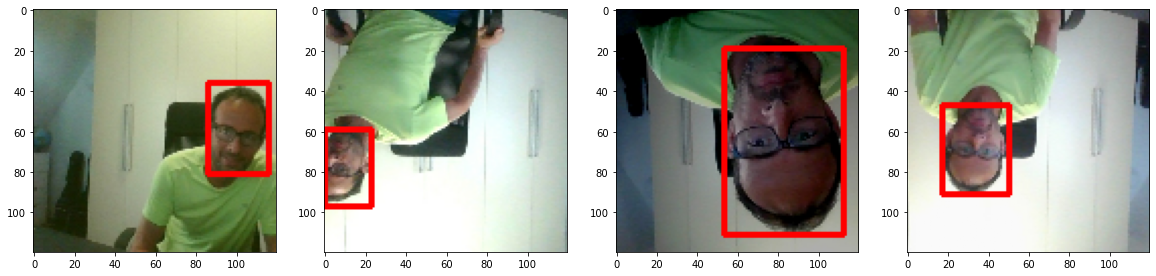

In [110]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

Per creare il modello di Object detection verrà utilizzato VGG16 già trained.

VGG16 è un classification module che noi dovremo modificare per poter fare object detection

In [112]:
vgg = VGG16(include_top=False)

In [113]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

Dopo aver definito l'input layer che accetti immagini della dimensione prestabilita nei nostri dataset (120,120,3), devono essere definiti gli autput.

Questi avranno lo stesso formato delle nostre annotattions: classe (quindi classification output) + boundingBoxes (regression output)

In questo modo il nostro modello avrà 2 head:
- classification head
- regression head

In [117]:
def build_model(): 
    
    # Input layer
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)   # estrae solo i max values dell'output layer del VGG16
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Per dimostrare che l'output corrisponde al formato delle nostre annotations

In [118]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1688, 0.525 , 0.3818, 0.8257],
        [0.1082, 0.3806, 0.3699, 0.6987],
        [0.5713, 0.246 , 0.8247, 0.583 ],
        [0.61  , 0.3381, 0.904 , 0.713 ],
        [0.3086, 0.3223, 0.562 , 0.6973],
        [0.5444, 0.3533, 0.798 , 0.7285],
        [0.038 , 0.3145, 0.3215, 0.6904],
        [0.558 , 0.4434, 0.8335, 0.8125]], dtype=float16))

### 8.4 Test out Neural Network

In [119]:
facetracker = build_model()

In [120]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

Estraiamo un sample dalla nostra pipeline

In [121]:
X, y = train.as_numpy_iterator().next()

X è l'immagine e y è la label

In [122]:
X.shape

(8, 120, 120, 3)

A titolo di esempio proviamo ad utilizzare in nostro modello (che non è ancora trained) per effettuare una prediction

In [123]:
classes, coords = facetracker.predict(X)

In [124]:
classes, coords

(array([[0.5888852 ],
        [0.61326677],
        [0.4592123 ],
        [0.5249943 ],
        [0.5007935 ],
        [0.52507657],
        [0.47225136],
        [0.53503954]], dtype=float32),
 array([[0.50372994, 0.5447514 , 0.7216425 , 0.76937234],
        [0.53795934, 0.5078189 , 0.7195214 , 0.69552165],
        [0.5503634 , 0.324852  , 0.7091887 , 0.67537546],
        [0.4709992 , 0.40821993, 0.5888692 , 0.7847922 ],
        [0.54937154, 0.5346195 , 0.7462751 , 0.74233013],
        [0.4921616 , 0.5016776 , 0.7382524 , 0.7316002 ],
        [0.49318475, 0.4915987 , 0.6714264 , 0.73312676],
        [0.5752282 , 0.4578471 , 0.6977287 , 0.7383401 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [125]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [126]:
lr_decay

0.0007047216349541929

In [127]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

Per la localization loss definisco una funzione custom mentre per la classification loss utilizzo BinaryCrossentropy

In [128]:
def localization_loss(y_true, yhat):    
    
    # calcolo la differenza (al quadrato) tra le coordinate effettive e le coordinate calcolate
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    # calcolo le altezze e larghezze effettive del box
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [130]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [131]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7954384>

In [132]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6440649>

In [133]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7954384>

# 10. Train Neural Network

Dobbiamo creare la training pipeline tramite subclass della classe Model

### 10.1 Create Custom Model Class

In [140]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    # riceve un batch di dati ed effettua il processo di training con quei dati 
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [141]:
model = FaceTracker(facetracker)

In [142]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [143]:
logdir='logs'

In [144]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [145]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 869s 2s/step - total_loss: 0.2271 - class_loss: 0.0557 - regress_loss: 0.1993 - val_total_loss: 0.0314 - val_class_loss: 2.5579e-05 - val_regress_loss: 0.0314
Epoch 2/10
473/473 [==============================] - 957s 2s/step - total_loss: 0.0597 - class_loss: 0.0170 - regress_loss: 0.0512 - val_total_loss: 0.0619 - val_class_loss: 6.7665e-04 - val_regress_loss: 0.0615
Epoch 3/10
473/473 [==============================] - 968s 2s/step - total_loss: 0.0288 - class_loss: 0.0086 - regress_loss: 0.0246 - val_total_loss: 0.0221 - val_class_loss: 4.8503e-05 - val_regress_loss: 0.0220
Epoch 4/10
473/473 [==============================] - 962s 2s/step - total_loss: 0.0227 - class_loss: 0.0070 - regress_loss: 0.0192 - val_total_loss: 0.0088 - val_class_loss: 7.5236e-05 - val_regress_loss: 0.0088
Epoch 5/10
473/473 [==============================] - 915s 2s/step - total_loss: 0.0126 - class_loss: 0.0039 - regress_loss: 0.0106 - val_total_loss

### 10.3 Plot Performance

In [146]:
hist.history

{'total_loss': [0.012921934016048908,
  0.017154907807707787,
  0.0022419122979044914,
  0.0049291676841676235,
  0.006994401104748249,
  0.001993876416236162,
  0.0059180958196520805,
  0.015631889924407005,
  0.46187132596969604,
  0.002597993705421686],
 'class_loss': [0.0005539422272704542,
  5.162032903172076e-05,
  8.910958968044724e-06,
  2.5436987925786525e-05,
  4.917386604574858e-07,
  0.00011698729213094339,
  0.0013011139817535877,
  0.00015864278248045594,
  0.726876437664032,
  0.0003845873288810253],
 'regress_loss': [0.012644963338971138,
  0.017129097133874893,
  0.002237456850707531,
  0.004916449077427387,
  0.006994155235588551,
  0.0019353828392922878,
  0.00526753906160593,
  0.015552569180727005,
  0.09843309223651886,
  0.0024057000409811735],
 'val_total_loss': [0.03137403354048729,
  0.06188550963997841,
  0.0220574252307415,
  0.008839518763124943,
  0.005508803762495518,
  0.004912166390568018,
  0.008053396828472614,
  0.0037773954682052135,
  0.01012638770

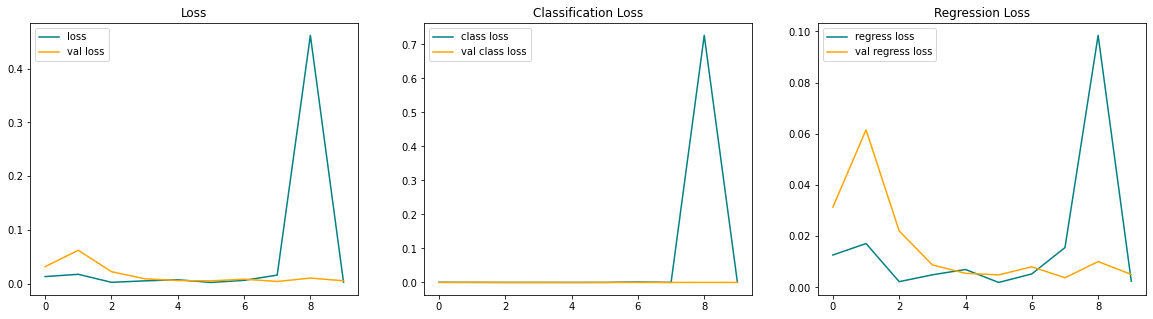

In [147]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [148]:
test_data = test.as_numpy_iterator()

In [155]:
test_sample = test_data.next()

In [156]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


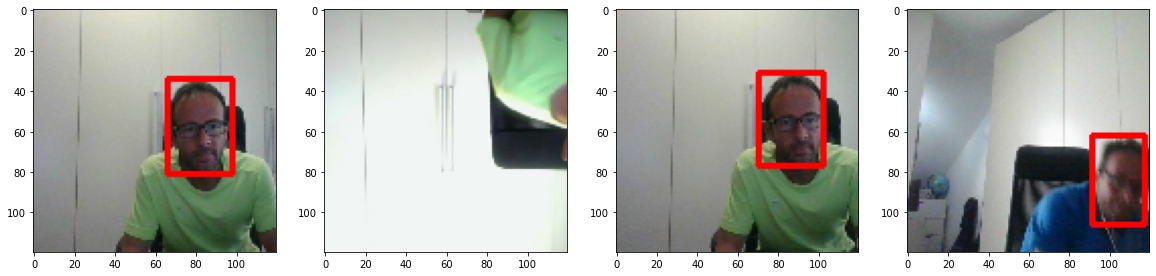

In [157]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [5]:
from tensorflow.keras.models import load_model

In [159]:
facetracker.save('facetracker.h5')

In [6]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()